In [74]:
import numpy as np
import pandas as pd
import msgpack
import msgpack_numpy as m
import base64

from time import time

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
#import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer,StandardScaler
from sklearn.feature_selection import VarianceThreshold

from sklearn.linear_model import LogisticRegression, SGDClassifier, PassiveAggressiveClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
#from sklearn.neural_network import MLPClassifier

from sklearn.learning_curve import learning_curve, validation_curve
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, precision_recall_curve
from sklearn.externals import joblib

from imblearn.combine import SMOTEENN
from imblearn.under_sampling import ClusterCentroids, CondensedNearestNeighbour, NearMiss, RandomUnderSampler

import os
import sys

sys.path.append(os.path.join(os.getcwd(), 'online-click-prediction'))
import utils as u

# Read log data

In [75]:
dt_edu = pd.read_csv("edu.log", sep="\||\:", usecols=[1,3,5], index_col=[0], names=['requestID','requestValue', 'click'], header=None, engine='python')
dt_subm = pd.read_csv("predict.log", sep="\||\:", usecols=[1,3], index_col=[0], names=['requestID','requestValue'], header=None, engine='python')

y = dt_edu['click']

X = u.process_log_data(dt_edu['requestValue'])
X_subm = u.process_log_data(dt_subm['requestValue'])

X.head()

key                                  bid_request_body                          \
ind                                               0    1           2      3     
b'requestID'                                                                    
34-d91ba231397e48aabaf6f35eb47016e6               0.0  0.0  19997003.0   57.0   
152-406A70020FFC2BBC5BC969FC1E344AAB              0.0  0.0  52669052.0  213.0   
34-1c3b9d4cf54c42adb0e1dc8797f386ec               0.0  0.0  20530698.0  293.0   
34-24c78e7b21c34e009d8a9896976f79f8               0.0  0.0  19997003.0   57.0   
34-b90166270e1d4f5aa6ed9dbe4601d615               0.0  0.0  54211958.0  318.0   

key                                                                 ...        \
ind                                   4    5    6    7    8    9    ...   517   
b'requestID'                                                        ...         
34-d91ba231397e48aabaf6f35eb47016e6   0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   
152-406A70020FFC2BBC5BC969FC1E344AAB  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   
34-1c3b9d4cf54c42adb0e1dc8797f386ec   0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   
34-24c78e7b21c34e009d8a9896976f79f8   0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   
34-b90166270e1d4f5aa6ed9dbe4601d615   0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   

key                                                                            \
ind                                   518  519          520          521  522   
b'requestID'                                                                    
34-d91ba231397e48aabaf6f35eb47016e6   2.0  0.0   70395263.0  100274130.0  0.0   
152-406A70020FFC2BBC5BC969FC1E344AAB  1.0  0.0   75128266.0   10773024.0  0.0   
34-1c3b9d4cf54c42adb0e1dc8797f386ec   2.0  0.0          0.0    2058778.0  0.0   
34-24c78e7b21c34e009d8a9896976f79f8   2.0  0.0  256389514.0  264283846.0  0.0   
34-b90166270e1d4f5aa6ed9dbe4601d615   1.0  0.0  236551568.0   52546098.0  0.0   

key                                            weight_funnel_stage_0        
ind                                   523  524                   0     1    
b'requestID'                                                                
34-d91ba231397e48aabaf6f35eb47016e6   0.0  0.0                  8965  2389  
152-406A70020FFC2BBC5BC969FC1E344AAB  0.0  0.0                  8965  2389  
34-1c3b9d4cf54c42adb0e1dc8797f386ec   0.0  0.0                  8965  2389  
34-24c78e7b21c34e009d8a9896976f79f8   0.0  0.0                  8965  2389  
34-b90166270e1d4f5aa6ed9dbe4601d615   0.0  0.0                  8965  2389  

[5 rows x 527 columns]

# Preprocessing data

In [76]:
rndst=12
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=rndst)#2
Xp_train, Xp_test, Xp_pred, Xp = X_train, X_test, X_subm, X

In [77]:
# remove all zero-variance features
vt = VarianceThreshold() 
Xp_train = vt.fit_transform(Xp_train)
Xp_test = vt.transform(Xp_test)
Xp_pred = vt.transform(Xp_pred)
Xp = vt.transform(Xp)

#### under-sampling 

In [72]:
#by Cluster Centroids
cc = ClusterCentroids()
Xp_train, y_train = cc.fit_sample(Xp_train, y_train)

In [86]:
# Apply Condensed Nearest Neighbours
cnn = CondensedNearestNeighbour()
Xp_train, y_train = cnn.fit_sample(Xp_train, y_train)

KeyboardInterrupt: 

In [35]:
# Apply Nearmiss 3
nm3 = NearMiss(version=3)
Xp_train, y_train = nm3.fit_sample(Xp_train, y_train)

e:\Install\Anaconda3\lib\site-packages\imblearn\under_sampling\nearmiss.py:161: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn('The number of the samples to be selected is larger than'


In [15]:
# Apply Random Sampler
rus = RandomUnderSampler(random_state=rndst)
Xp_train, y_train = rus.fit_sample(Xp_train, y_train)

#### over-sampling 

In [41]:
# SMOTE and cleaning using ENN
sm = SMOTEENN()
Xp_train, y_train = sm.fit_sample(Xp_train, y_train)

In [78]:
# scale to mean=0, std=1
ss = StandardScaler() 
Xp_train = ss.fit_transform(Xp_train)
Xp_test = ss.transform(Xp_test)
Xp_pred = ss.transform(Xp_pred)
Xp = ss.transform(Xp)

In [79]:
print(Xp_train.shape, Xp_test.shape, Xp_pred.shape, Xp.shape)

(50355, 73) (16786, 73) (31314, 73) (67141, 73)


### Data visualization

In [80]:
pca = PCA(n_components=2).fit(Xp_train)
Xp_train_pca = pca.transform(Xp_train)
Xp_test_pca = pca.transform(Xp_test)
Xp_pred_pca = pca.transform(Xp_pred)
Xp_pca = pca.transform(Xp)

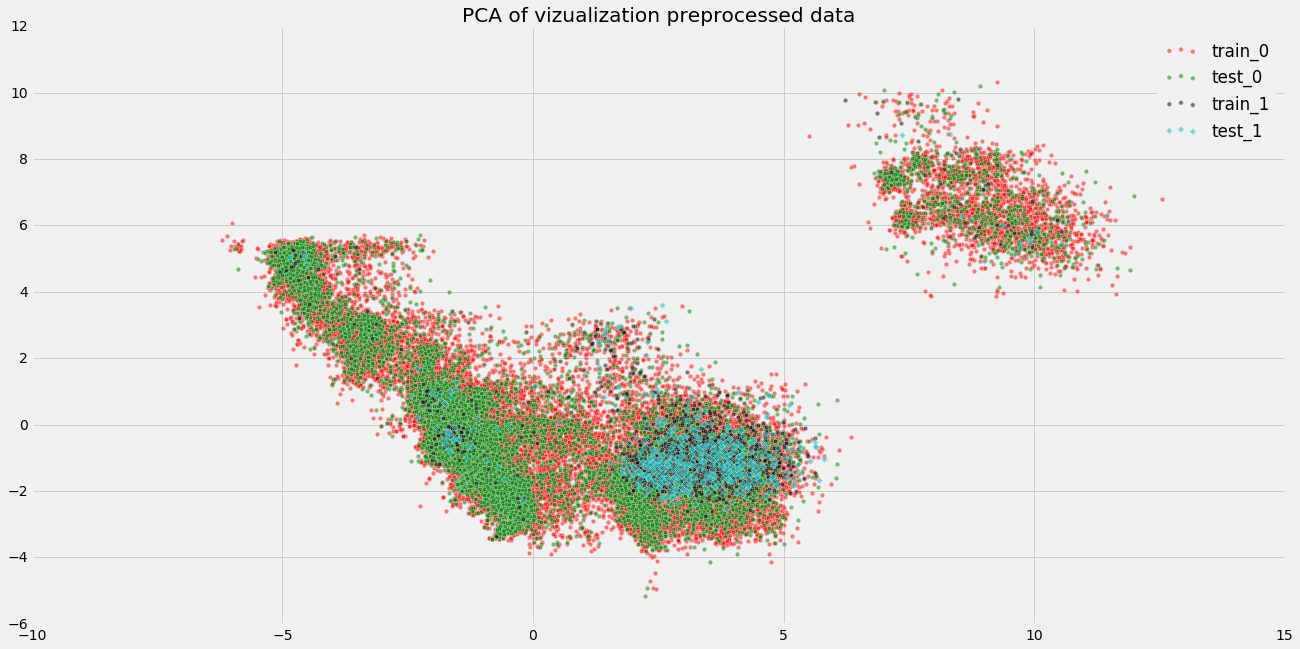

In [81]:
plt.figure(figsize=(20, 10))

#plt.scatter(Xp_pred_pca[:, 0], Xp_pred_pca[:, 1], c='b', label='pred')

plt.scatter(Xp_train_pca[y_train.values==0, 0], Xp_train_pca[y_train.values==0, 1], c='r', alpha=.5, label='train_0')
plt.scatter(Xp_test_pca[y_test.values==0, 0], Xp_test_pca[y_test.values==0, 1], c='g', alpha=.5, label='test_0')
#plt.scatter(Xp_pred_pca[Yp_pred==0, 0], Xp_pred_pca[Yp_pred==0, 1], c='y', marker='D', alpha=.5, label='pred_0')

plt.scatter(Xp_train_pca[y_train.values==1, 0], Xp_train_pca[y_train.values==1, 1], c='k', marker='o', alpha=.5, label='train_1')
plt.scatter(Xp_test_pca[y_test.values==1, 0], Xp_test_pca[y_test.values==1, 1], c='c', marker='D', alpha=.5, label='test_1')
#plt.scatter(Xp_pred_pca[Yp_pred==1, 0], Xp_pred_pca[Yp_pred==1, 1], c='m', marker='D', alpha=.5, label='pred_1')

plt.legend()
plt.title('PCA of vizualization preprocessed data')

plt.show()

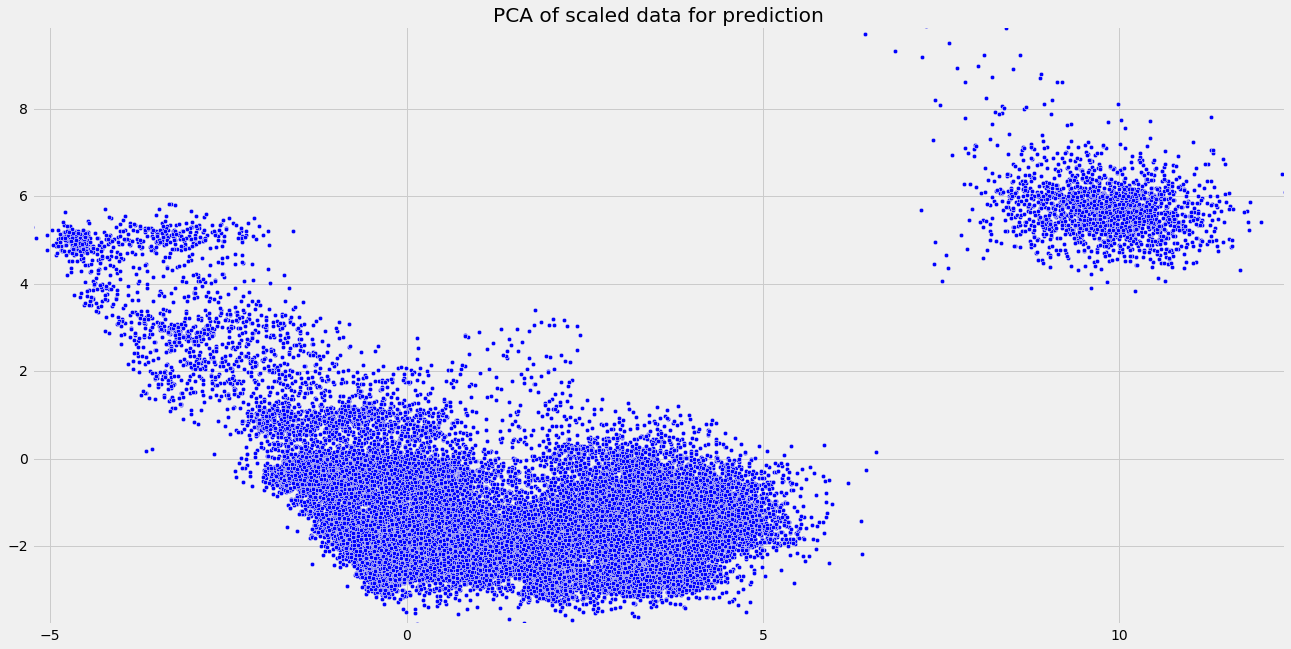

In [82]:
u.plot_2d(Xp_pred_pca, 'PCA of scaled data for prediction')

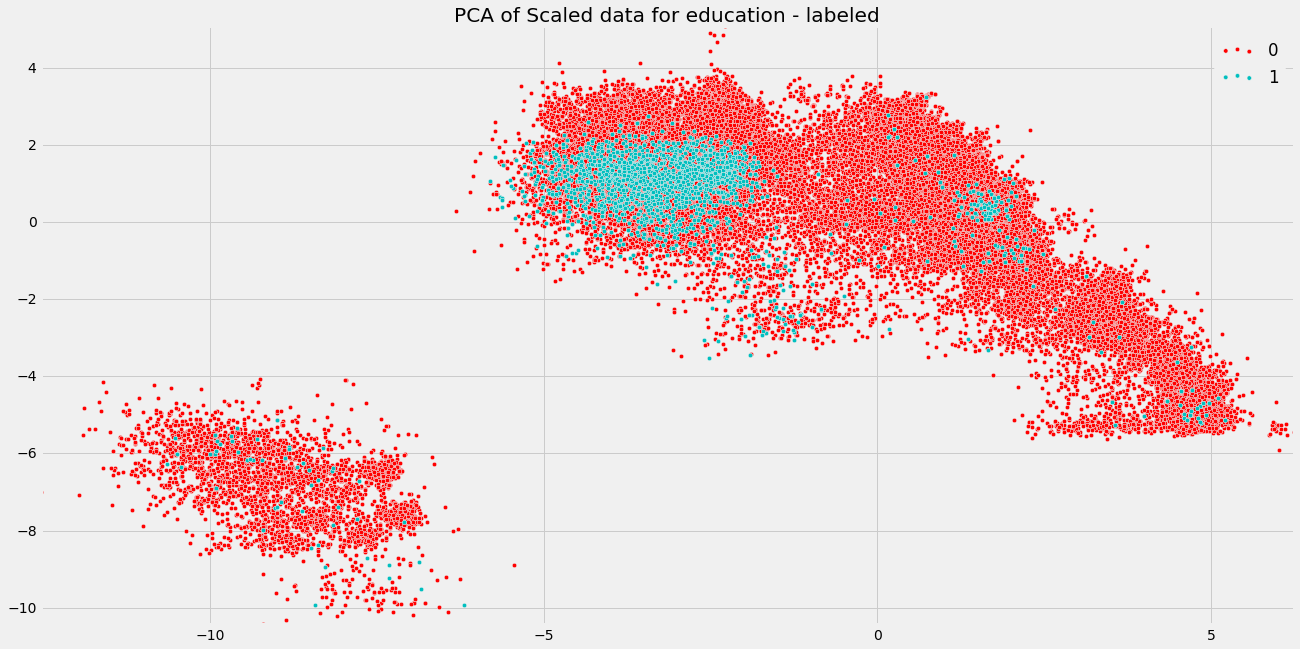

In [319]:
u.plot_2d_labled(Xp_pca, y, 'PCA of Scaled data for education - labeled')

#### Distribution of data for education

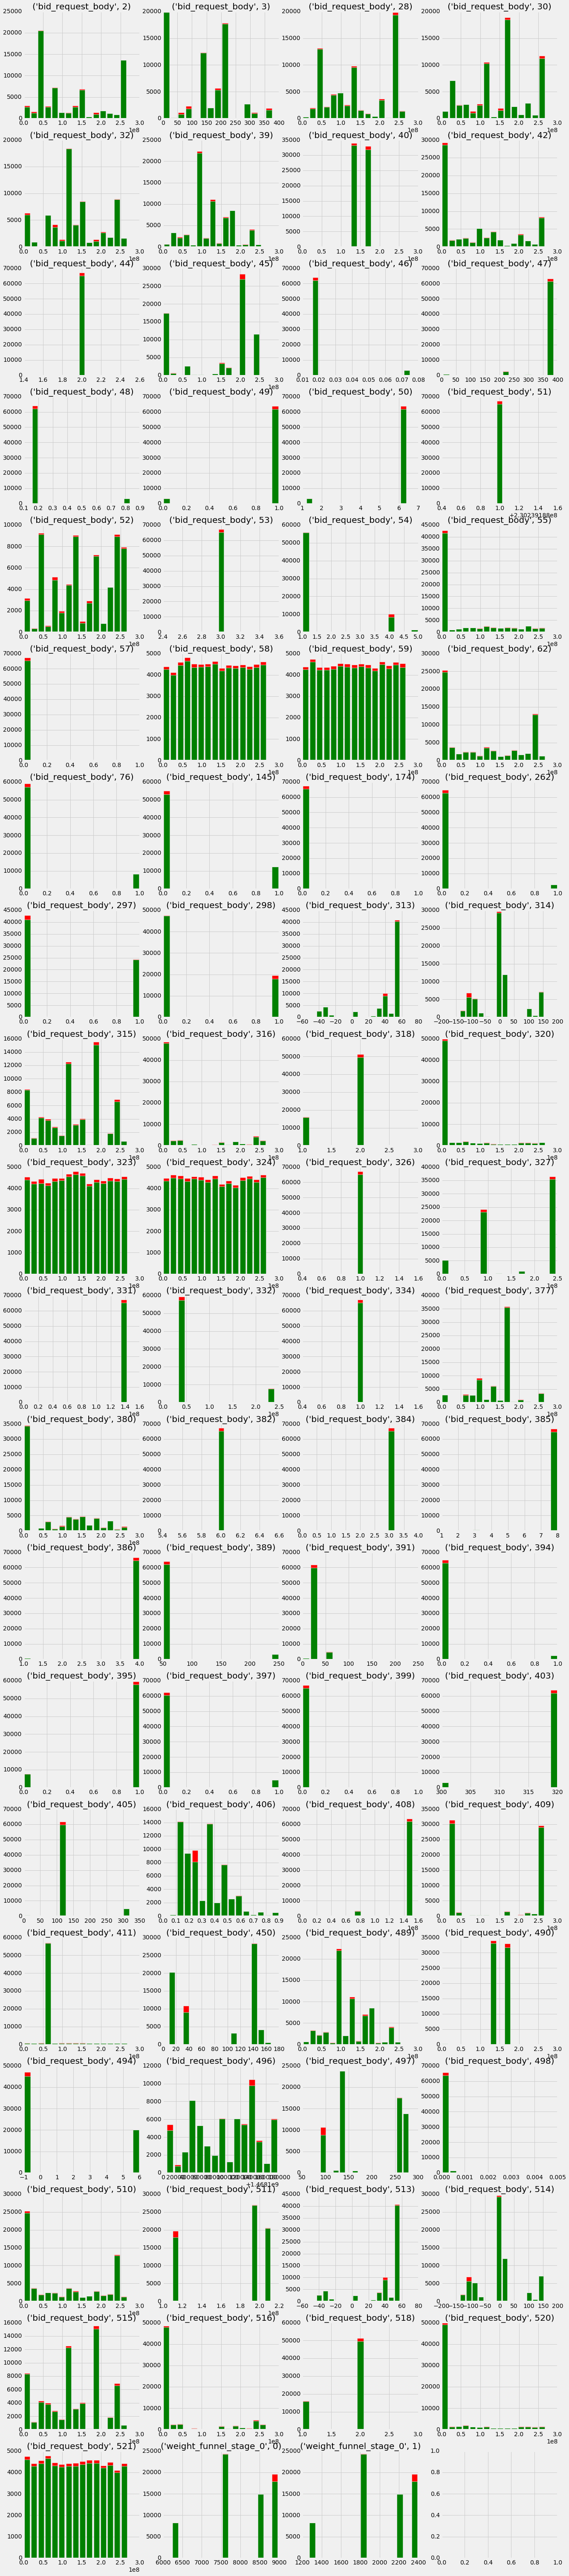

In [280]:
Xnot0 = X.loc[:, X.sum(axis=0) > 0] # non Zero features only

fig, ax = plt.subplots(np.ceil(Xnot0.shape[1]/4), 4, figsize=[20, 100])
for i, fe in enumerate(list(Xnot0.columns.values)):
    ax.flat[i].hist([Xnot0[(y.values == v)][fe] for v in [0, 1]], \
                    bins=15, stacked=True, label=['no', 'yes'], color=['g','r'])
    #ax.flat[i].legend()
    ax.flat[i].set_title(fe)

#### Distribution of data for prediction

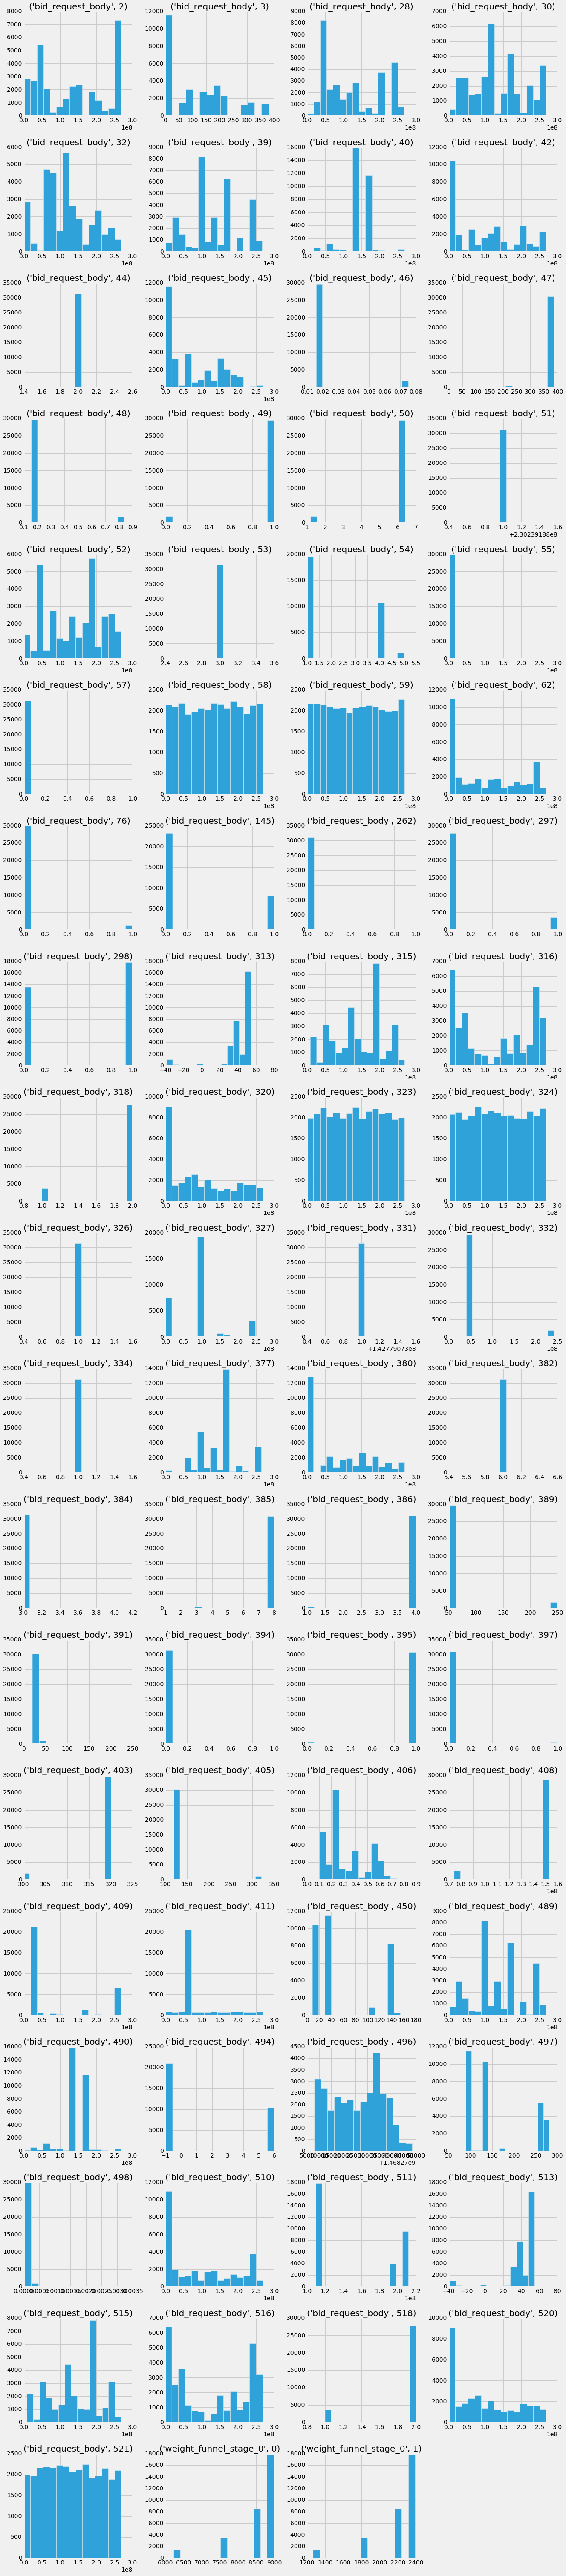

In [284]:
plt.figure()
#with plt.style.context(('default')):
X_subm.loc[:, X_subm.sum(axis=0) > 0].hist(bins=15, figsize=(20, 100), layout = (-1, 4), sharex=False, sharey=False)
plt.show()

# Model selection

### SGDClassifier

In [45]:
# find best model parameters
sgdc_param_grid = {"loss": ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
                   "alpha": np.logspace(-5., -1., 5), # np.linspace(0.0001, 0.1, 5)
                   "penalty": ['l2', 'l1', 'elasticnet'],             
                   "l1_ratio": np.linspace(0.1, 0.9, 5)
                   #"class_weight":[dict([(0, 0.25),(1, i/4)]) for i in np.linspace(2., np.bincount(y)[0]/np.bincount(y)[1], 5)],
                   #"average": [False, True]
                  }

#### roc_auc

In [38]:
# run grid search
sgdc_grid_search_rocauc = GridSearchCV(SGDClassifier(l1_ratio = 0.7, n_iter=10), param_grid=sgdc_param_grid, scoring='roc_auc', verbose=1)
sgdc_grid_search_rocauc.fit(Xp_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=True),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'loss': ['hinge', 'log', 'modified_huber'], 'class_weight': ['balanced', None], 'penalty': ['l2', 'l1', 'elasticnet'], 'alpha': array([  1.00000e-05,   1.00000e-04,   1.00000e-03,   1.00000e-02,
         1.00000e-01]), 'l1_ratio': array([ 0.1,  0.3,  0.5,  0.7,  0.9]), 'average': [False, True]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [39]:
# by roc_auc
print("best_model_score: ", sgdc_grid_search_rocauc.best_score_, "\nbest_model_params: ", sgdc_grid_search_rocauc.best_params_)

best_model_score:  0.930576548119 
best_model_params:  {'loss': 'log', 'class_weight': None, 'penalty': 'l1', 'alpha': 0.0001, 'l1_ratio': 0.90000000000000002, 'average': False}


In [83]:
sgdc_best_rocauc = SGDClassifier(loss= 'log', alpha= 0.0001, penalty= 'l1', class_weight='balanced', n_iter=100)#'balanced'

Stratified 3-Fold cross-validation 
train_scores_mean:
[ 0.94734027  0.91949039  0.90510279  0.89659296  0.90987717]
test_scores_mean:
[ 0.86960838  0.89648409  0.89403531  0.89109508  0.90709498]


<module 'matplotlib.pyplot' from 'e:\\Install\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

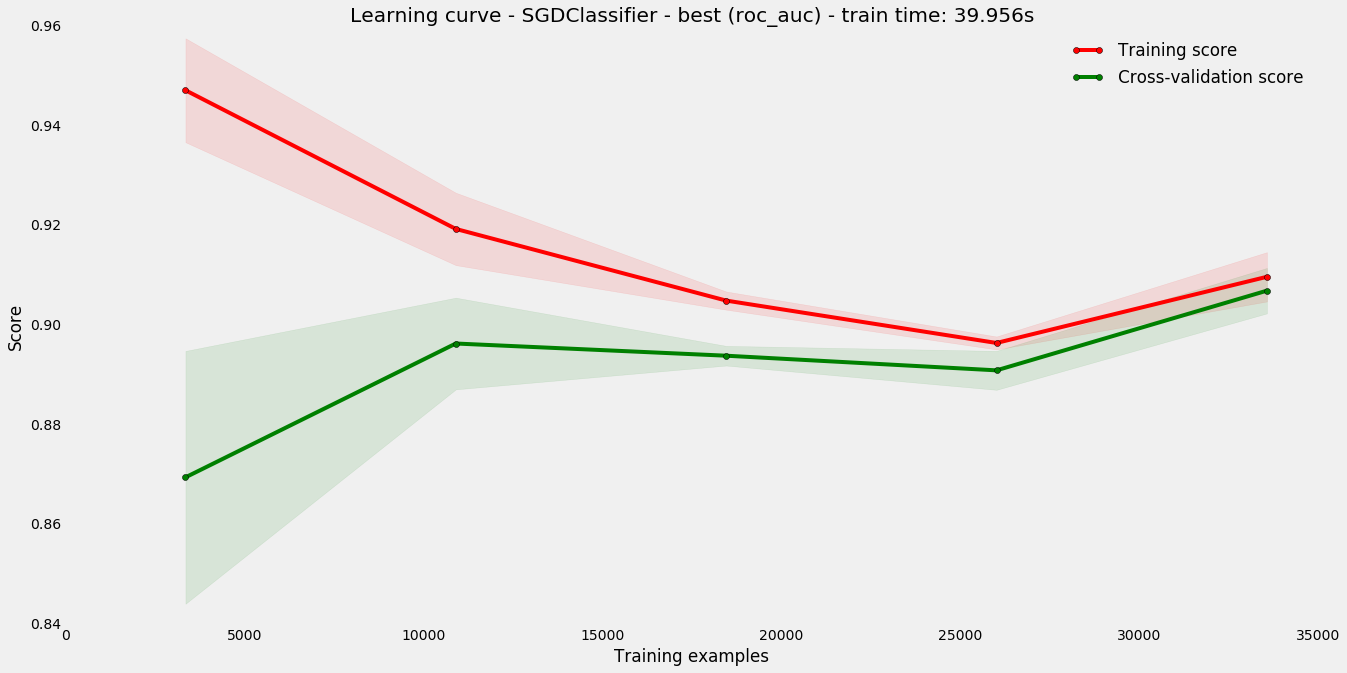

In [375]:
u.plot_learning_curve(sgdc_best_rocauc, "Learning curve - SGDClassifier - best (roc_auc)", Xp_train, y_train, scoring='roc_auc')

In [84]:
sgdc_best_rocauc.fit(Xp_train, y_train)
print("ROC_AUC score for out-of-samle data (stratified): %0.4f" % roc_auc_score(y_test, sgdc_best_rocauc.predict_proba(Xp_test)[:,1]))

ROC_AUC score for out-of-samle data (stratified): 0.9126


#### f1

In [46]:
n_iter_search = 25
# run grid search
sgdc_grid_search_f1 = RandomizedSearchCV(SGDClassifier(n_iter=10), param_distributions=sgdc_param_grid, n_iter=n_iter_search, 
                                         scoring='f1', verbose=1)
sgdc_grid_search_f1.fit(Xp_train, y_train)

# by f1
print("best_model_score: ", sgdc_grid_search_f1.best_score_, "\nbest_model_params: ", sgdc_grid_search_f1.best_params_)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    0.9s
e:\Install\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
e:\Install\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


best_model_score:  0.722088073104 
best_model_params:  {'l1_ratio': 0.5, 'penalty': 'l1', 'loss': 'hinge', 'alpha': 0.01}


[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    1.3s finished


In [47]:
sgdc_best_f1 = SGDClassifier(loss= 'hinge', alpha= 0.01, penalty= 'l1', l1_ratio = 0.5, n_iter=10)#'balanced'

ValueError: The number of class labels must be greater than one.

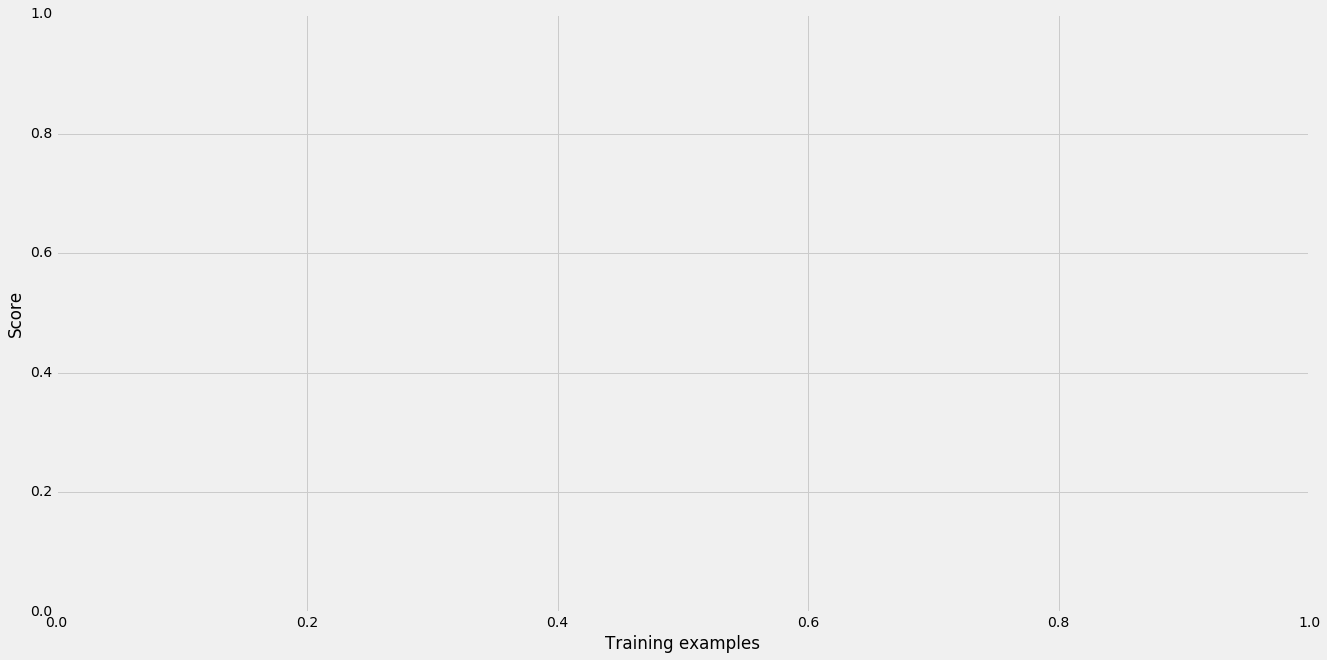

In [48]:
u.plot_learning_curve(sgdc_best_f1, "Learning curve - SGDClassifier - best (f1)", Xp_train, y_train, scoring='f1')

In [49]:
sgdc_best_f1.fit(Xp_train, y_train)
#print("ROC_AUC score for out-of-samle data (stratified): %0.4f" % roc_auc_score(y_test, sgdc_best_f1.predict_proba(Xp_test)[:,1]))

SGDClassifier(alpha=0.01, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.5, learning_rate='optimal',
       loss='hinge', n_iter=10, n_jobs=1, penalty='l1', power_t=0.5,
       random_state=None, shuffle=True, verbose=0, warm_start=False)

### dump model

In [85]:
joblib.dump(sgdc_best_rocauc, 'sgdc_best.pkl')

['sgdc_best.pkl',
 'sgdc_best.pkl_01.npy',
 'sgdc_best.pkl_02.npy',
 'sgdc_best.pkl_03.npy',
 'sgdc_best.pkl_04.npy']

In [50]:
joblib.dump(sgdc_best_f1, 'sgdc_best.pkl')

['sgdc_best.pkl',
 'sgdc_best.pkl_01.npy',
 'sgdc_best.pkl_02.npy',
 'sgdc_best.pkl_03.npy',
 'sgdc_best.pkl_04.npy']

### evaluate model

In [86]:
Yp_train = u.predict_online('sgdc_best.pkl',Xp_train)

Yp_test = u.predict_online('sgdc_best.pkl',Xp_test)
Yp_test_proba = u.predict_online('sgdc_best.pkl',Xp_test, proba=1)

Yp_pred = u.predict_online('sgdc_best.pkl',Xp_pred)

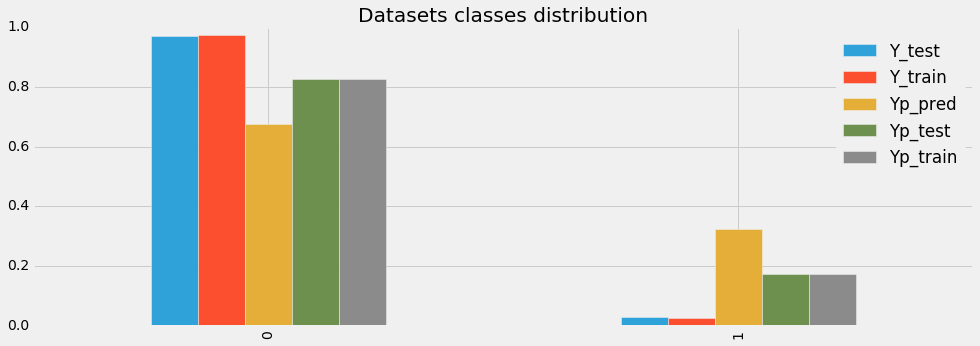

In [87]:
cls_dist = pd.DataFrame({'Y_train': np.unique(y_train, return_counts=True)[1],
              'Yp_train': np.unique(Yp_train, return_counts=True)[1],
              'Y_test': np.unique(y_test, return_counts=True)[1],
              'Yp_test': np.unique(Yp_test, return_counts=True)[1],
              'Yp_pred': np.unique(Yp_pred, return_counts=True)[1]})
(cls_dist/cls_dist.sum(axis=0)).plot(kind='bar', title='Datasets classes distribution', figsize=(15,5))

In [88]:
pd.concat([cls_dist, np.round(cls_dist/cls_dist.sum(axis=0),3)], keys=['count', 'share'], axis=1)

count                                   share                          \
  Y_test Y_train Yp_pred Yp_test Yp_train Y_test Y_train Yp_pred Yp_test   
0  16271   48949   21208   13861    41641  0.969   0.972   0.677   0.826   
1    515    1406   10106    2925     8714  0.031   0.028   0.323   0.174   

            
  Yp_train  
0    0.827  
1    0.173

In [89]:
print(#"ROC_AUC score for out-of-samle data (stratified): %0.4f" % roc_auc_score(y_test, Yp_test_proba), 
      '\n\nClassification_report:\n',classification_report(y_test, Yp_test), 
      '\n\nConfusion_matrix:\n', confusion_matrix(y_test, Yp_test))#,'\n\n', confusion_matrix(y_train, Yp_train))



Classification_report:
              precision    recall  f1-score   support

          0       1.00      0.85      0.92     16271
          1       0.16      0.90      0.27       515

avg / total       0.97      0.85      0.90     16786
 

Confusion_matrix:
 [[13809  2462]
 [   52   463]]


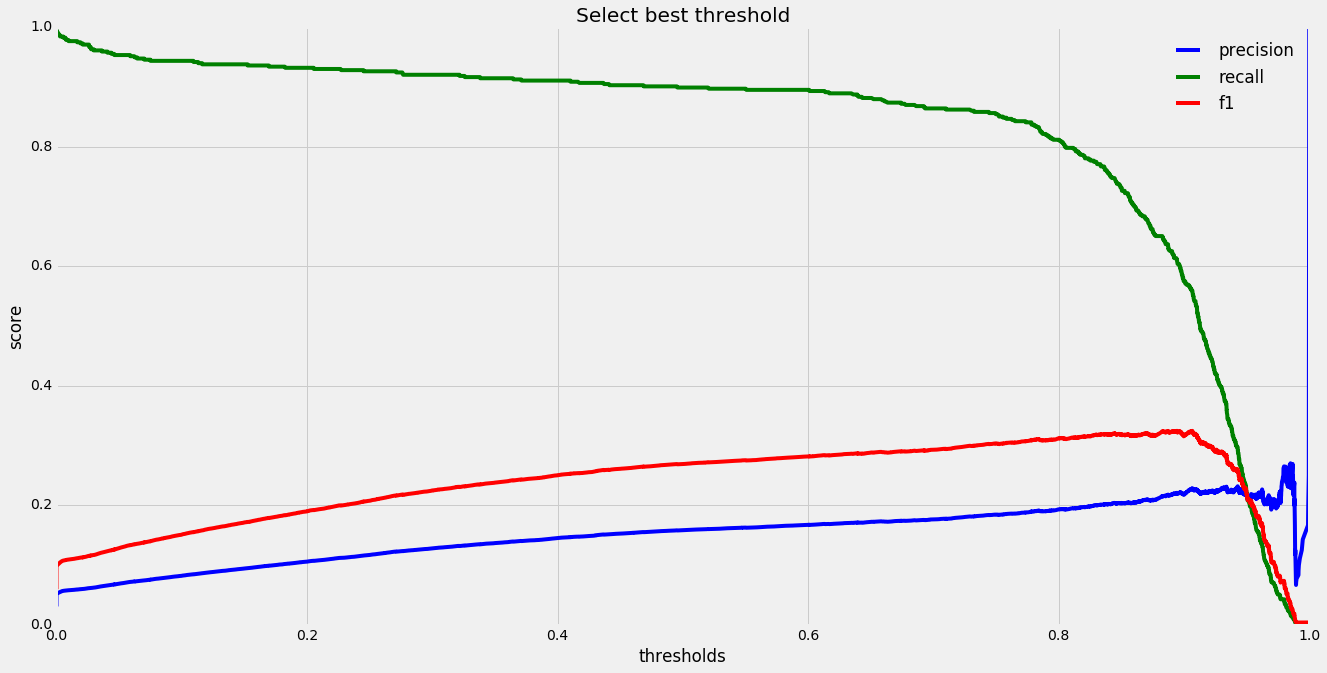

In [90]:
precision, recall, thresholds = precision_recall_curve(y_test, Yp_test_proba)
thresholds = np.append(thresholds,np.nan)

plt.figure(figsize=(20, 10))

plt.plot(thresholds, precision, c='b', label='precision')
plt.plot(thresholds, recall, c='g', label='recall')
plt.plot(thresholds, 2 * (precision * recall) / (precision + recall), c='r', label='f1')

plt.legend()
plt.title('Select best threshold')
plt.ylabel('score')
plt.xlabel('thresholds')
plt.show()

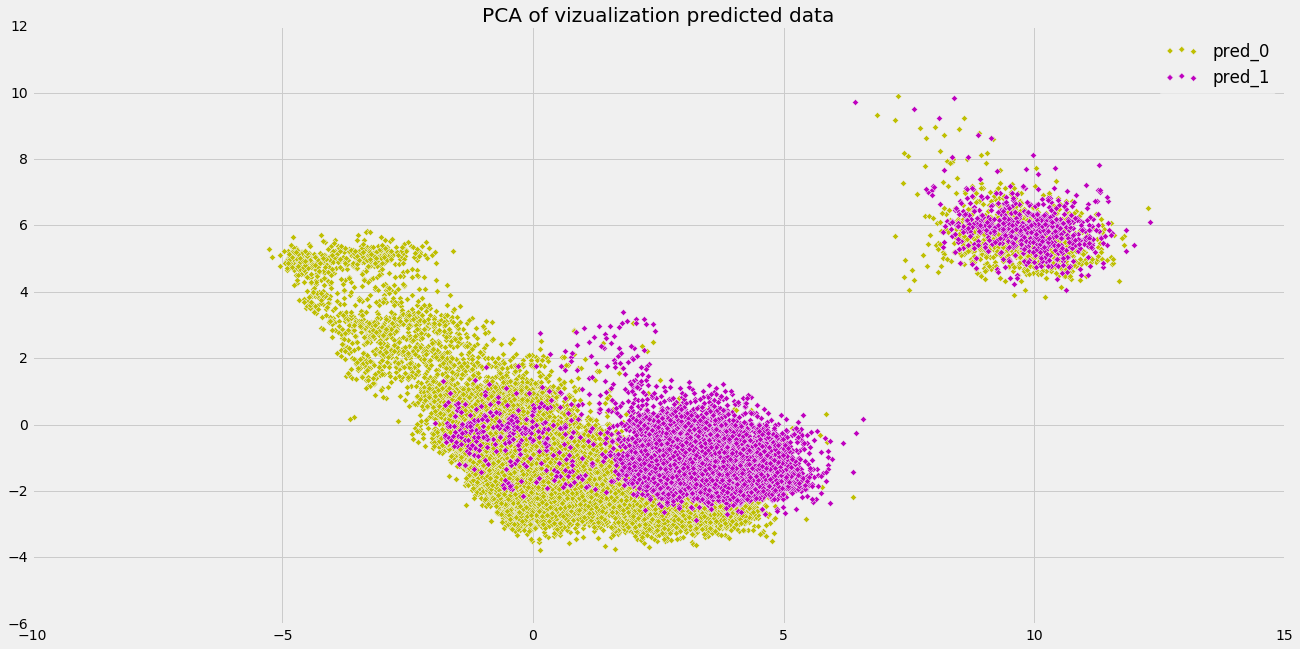

In [92]:
plt.figure(figsize=(20, 10))

#plt.scatter(Xp_pred_pca[:, 0], Xp_pred_pca[:, 1], c='b', label='pred')

#plt.scatter(Xp_train_pca[y_train==0, 0], Xp_train_pca[y_train==0, 1], c='r', label='train_0')
#plt.scatter(Xp_test_pca[y_test.values==0, 0], Xp_test_pca[y_test.values==0, 1], c='g', label='test_0')
plt.scatter(Xp_pred_pca[Yp_pred==0, 0], Xp_pred_pca[Yp_pred==0, 1], c='y', marker='D', label='pred_0')

#plt.scatter(Xp_train_pca[y_train==1, 0], Xp_train_pca[y_train==1, 1], c='k', marker='o', label='train_1')
#plt.scatter(Xp_test_pca[y_test.values==1, 0], Xp_test_pca[y_test.values==1, 1], c='c', marker='D', label='test_1')
plt.scatter(Xp_pred_pca[Yp_pred==1, 0], Xp_pred_pca[Yp_pred==1, 1], c='m', marker='D', label='pred_1')

plt.legend()
plt.title('PCA of vizualization predicted data')

plt.show()

# Make prediction

### Real time learning (by batches)

In [120]:
sgdc_online = SGDClassifier(loss= 'log', alpha= 0.0001, penalty= 'l1', warm_start= True)

In [121]:
joblib.dump(sgdc_online, 'sgdc_online.pkl')

['sgdc_online.pkl']

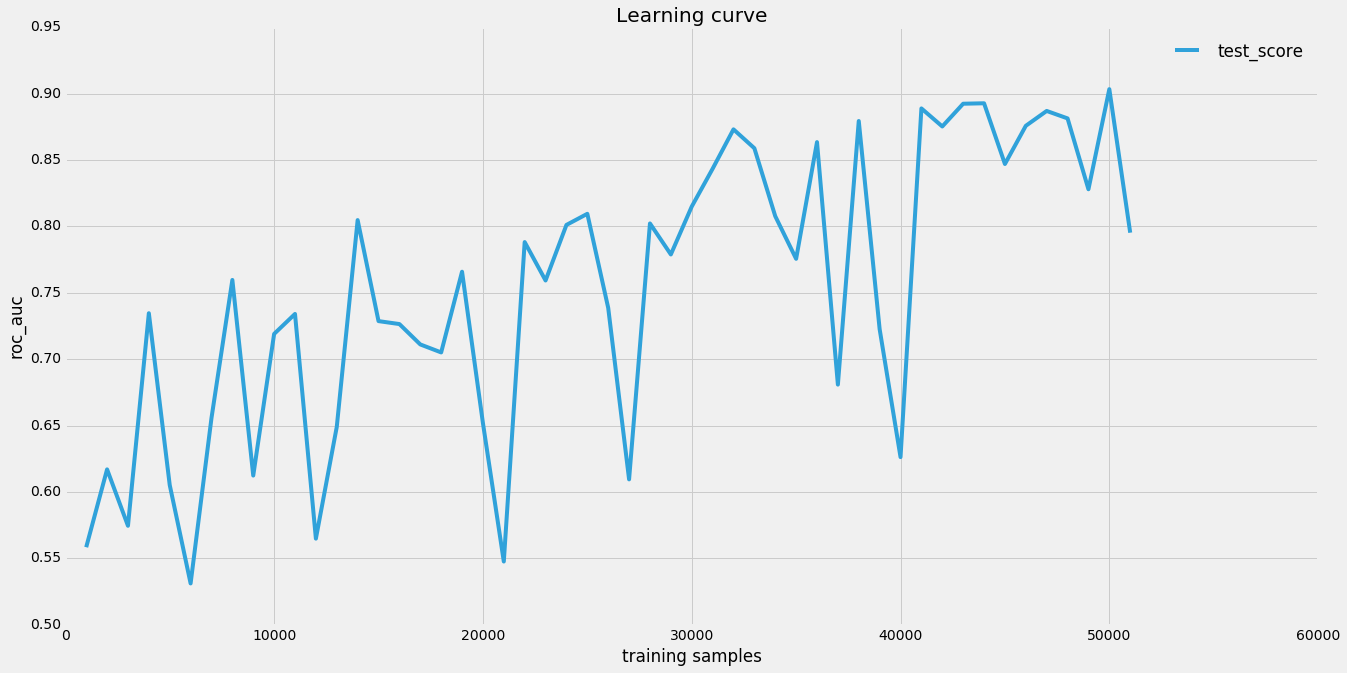

In [122]:
bs=1000
test_score = []
for batch in u.batches(range(len(X_train)), bs):
    tmp = u.train_online('sgdc_online.pkl', X_train[batch[0]:batch[-1]+1], y_train[batch[0]:batch[-1]+1])
    test_score.append(roc_auc_score(y_test, u.predict_online('sgdc_online.pkl', X_test, proba=1)))

# Plot Learning curve for online learning
plt.figure(figsize=[20,10])
plt.plot(np.linspace(bs, bs*len(test_score), len(test_score)), test_score, label='test_score')
plt.ylabel('roc_auc')
plt.xlabel('training samples')
plt.title('Learning curve')
plt.legend(loc='best')
plt.show()

In [78]:
roc_auc_score(y_test, u.predict_online('sgdc_best.pkl',X_test, proba=1))

0.91607639314771661

In [79]:
roc_auc_score(y_test, u.predict_online('sgdc_online.pkl',X_test, proba=1))

0.81032793399157788

#### time for prediction

In [61]:
# time for single prediction
%timeit u.predict_online('sgdc_best.pkl',X_test[np.random.randint(1000, size=1)[0]].reshape(1, -1)) 

100 loops, best of 3: 3.49 ms per loop


In [63]:
# time for batch of predictions
%timeit u.predict_online('sgdc_best.pkl',X_test) 

100 loops, best of 3: 6.13 ms per loop


In [68]:
# time for batch of predictions
%timeit u.predict_online('sgdc_best.pkl',X_pred) 

100 loops, best of 3: 7.97 ms per loop


## Serialization of classifier

#### msgpack

In [22]:
sgdc_best.__dict__

{'C': 1.0,
 '_expanded_class_weight': array([ 1.,  1.]),
 'alpha': 0.0001,
 'average': False,
 'class_weight': None,
 'classes_': array([0, 1], dtype=int64),
 'coef_': array([[ -4.12993572e-01,  -9.87074007e-02,   3.40884929e-01,
           6.91314320e-01,   2.03267470e-01,  -3.52607524e-02,
           0.00000000e+00,   0.00000000e+00,   9.88331525e-02,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,  -2.17368418e-01,
           4.74436536e+01,   0.00000000e+00,  -5.38248002e+01,
           0.00000000e+00,   2.45763377e-01,   0.00000000e+00,
          -1.81126492e+00,  -3.52022377e+01,   0.00000000e+00,
          -1.11007511e+01,   2.47806523e+01,   9.80749683e+00,
          -2.45585204e-01,  -8.17310442e-02,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,  -1.37690117e+01,   0.00000000e+00,
           3.0

In [44]:
model = sgdc_best.__dict__

In [45]:
model = {'sgdc_params': sgdc_best.get_params(),
         'sgdc_coef_': sgdc_best.coef_,
         'sgdc_intercept_': sgdc_best.intercept_
        }

In [48]:
packed = base64.b64encode(msgpack.packb(model, default=m.encode, encoding = 'utf-8'))

In [58]:
unpacked = msgpack.unpackb(base64.b64decode(packed), object_hook=decode_b)

In [59]:
unpacked#.apply().decode()

{b'sgdc_coef_': array([[ -4.46641535e-01,  -3.89826627e-02,   3.74126288e-02,
           1.54791076e-01,   3.17066787e-01,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   3.25255096e-01,
          -1.60247033e-01,   0.00000000e+00,  -1.60247033e-01,
           1.60247033e-01,   1.60247033e-01,  -2.54289269e-01,
           4.64612384e+01,   0.00000000e+00,  -4.87766193e+01,
           0.00000000e+00,   0.00000000e+00,  -4.42949903e-02,
           0.00000000e+00,  -3.46918556e+01,   0.00000000e+00,
          -7.11437379e+00,   1.93572903e+01,   8.45879622e+00,
           0.00000000e+00,  -3.49161366e-01,   0.00000000e+00,
           0.00000000e+00,   2.04335089e-01,   0.00000000e+00,
          -1.16224272e-02,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,  -1.33755083e+01,   0.00000000e+00,
           2.12640824e-01,   0.00000000e+00,   1.45590455e+01,
           4.01182271e+00,  -1.60247033e-01,  -9.62964503e-02,
          -8.77134059e+00,   9.50955634e

In [62]:
back = SGDClassifier().set_params(**unpickled['sgdc_params'.encode()])
back.coef_=unpickled['sgdc_coef_'.encode()]
back.intercept_=unpickled['sgdc_intercept_'.encode()]

TypeError: set_params() keywords must be strings

#### pickle

In [41]:
import pickle
s = pickle.dumps(sgdc_best)
clf2 = pickle.loads(s)

In [131]:
X_train[0].reshape(1, -1)

array([[-1.17585637, -0.76590466, -0.14436197, -0.95142174, -0.49751849,
         0.92671129,  0.93506048,  0.4364893 ,  0.60981727, -0.22735637,
         0.23390805, -0.22735637,  0.22735637,  0.22735637, -0.27131341,
         2.12686641, -0.66075955, -0.03453902, -0.47399071,  0.55221222,
        -0.66716103, -0.37381942, -0.47365782, -0.00385931, -0.20054925,
        -0.75515287,  1.55596373,  0.53705036, -0.00862841,  0.09280284,
         2.50572338,  0.55858206,  0.49331511,  0.00533994,  0.49781646,
        -0.63238053,  0.01651484, -0.36611135, -1.1101912 , -0.44151471,
         0.0025265 ,  0.09019187,  0.08800478, -0.22735637, -0.22675057,
        -0.1899857 ,  0.35830467, -0.28396492, -0.06586354,  0.22735637,
        -0.25087025, -0.50600762,  0.22982171, -1.00651664, -0.00307946,
        -0.80051146,  0.92671129,  0.93506048, -0.65548256, -1.82232656,
        -1.31881371, -0.50600993, -0.66716103, -1.54556504,  0.53705036,
        -0.00862841,  0.09280284,  2.50572338,  0.5

In [42]:
sgdc_best.predict(X_train[3].reshape(1, -1))

array([1], dtype=int64)

In [43]:
clf2.predict(X_train[3].reshape(1, -1))

array([1], dtype=int64)

### PassiveAggressiveClassifier

In [354]:
pac = PassiveAggressiveClassifier(class_weight='balanced')

Stratified 3-Fold cross-validation 
train_scores_mean:
[ 0.23004206  0.19898534  0.1995191   0.23161519  0.20444744]
test_scores_mean:
[ 0.20613879  0.1963939   0.20022667  0.23262138  0.20619907]


<module 'matplotlib.pyplot' from 'e:\\Install\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

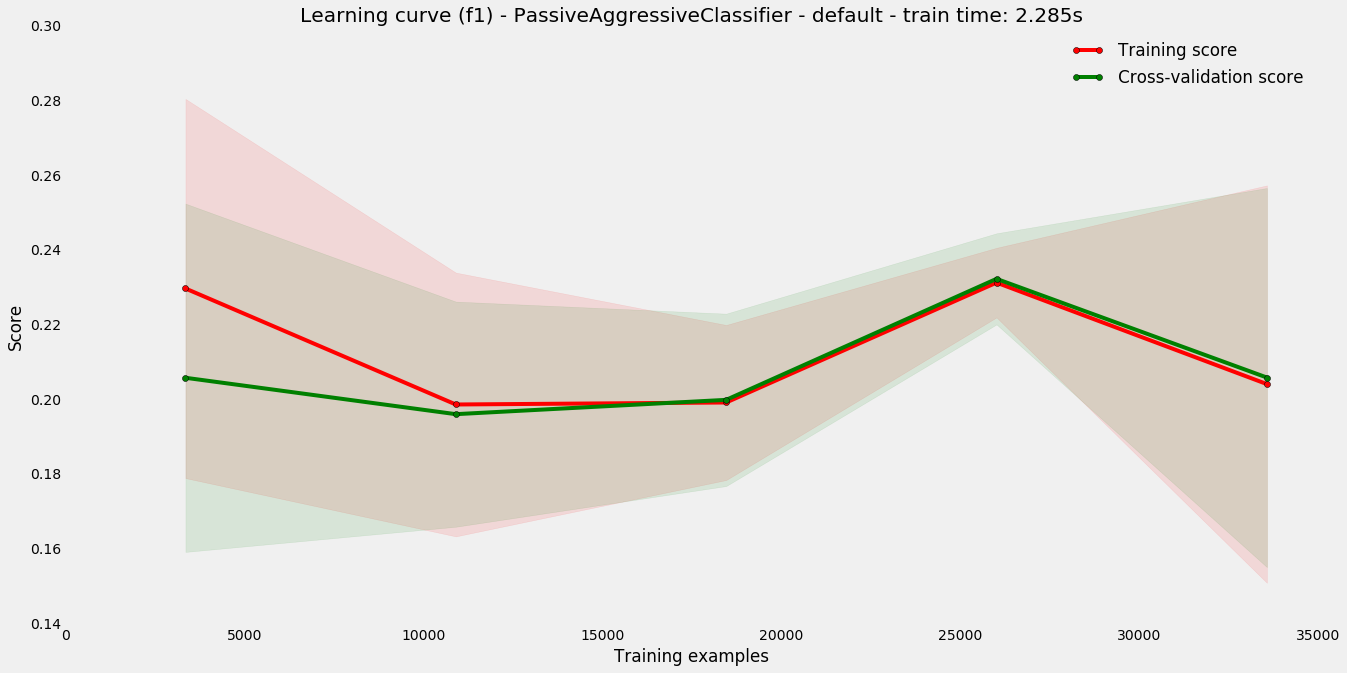

In [361]:
u.plot_learning_curve(pac, "Learning curve (f1) - PassiveAggressiveClassifier - default", Xp_train, y_train, scoring='f1')

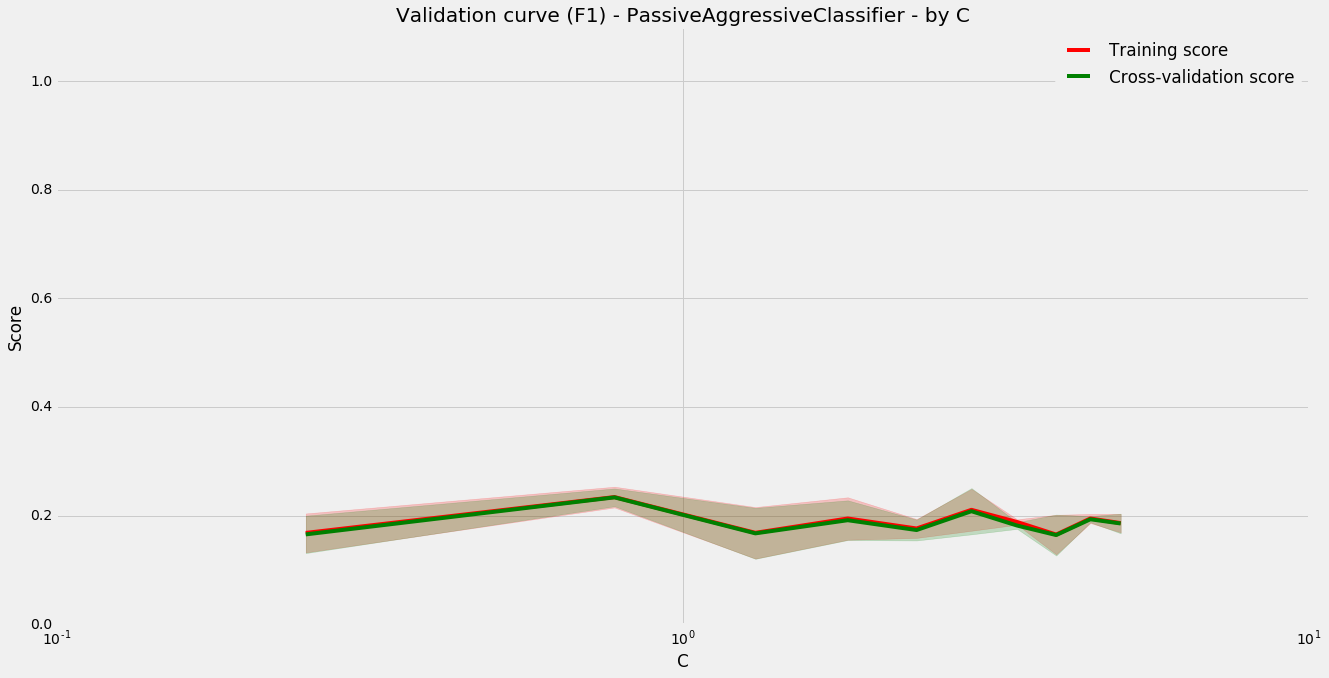

Stratified 3-Fold cross-validation 
train_scores_mean:
[ 0.16797408  0.23396271  0.1682064   0.19452649  0.17613799  0.21049704
  0.18809524  0.16495511  0.19456678  0.18603837]
test_scores_mean:
[ 0.16527225  0.23346291  0.1671962   0.19139542  0.17330601  0.20796597
  0.18154229  0.16407049  0.19313754  0.18538177]


<module 'matplotlib.pyplot' from 'e:\\Install\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [362]:
u.plot_validation_curve(pac, Xp_train, y_train, param_name="C", param_range = np.linspace(0.25, 5, 10), 
                      title="Validation curve (F1) - PassiveAggressiveClassifier - by C", ylim=(0.0, 1.1), scoring='f1')

In [ ]:
# specify parameters and distributions to sample from
pac_param_grid = {"C": np.linspace(0.1, 3, 5),
                  "loss": ['hinge', 'squared_hinge'], 
                  #"class_weight":['balanced', None],
                  "n_iter": np.linspace(5, 100, 5) 
                   #"fit_intercept": [False, True]
                  }
# run grid search
pac_grid_search_f1 = GridSearchCV(pac, param_grid=pac_param_grid, scoring='f1', verbose=1)
pac_grid_search_f1.fit(Xp_train, y_train)

In [79]:
# by f1
print("best_model_score: ", pac_grid_search_f1.best_score_, "\nbest_model_params: ", pac_grid_search_f1.best_params_)

array([ 1.,  2.,  3.,  4.,  5.])

### Gradient Boosting Classifier

In [55]:
# specify parameters and distributions to sample from
gbc_param_dist = {"loss": ['deviance', 'exponential'],
                  "learning_rate": np.linspace(0.01, 0.5, 10),
                  "n_estimators": list(range(50, 200, 5)),
                  "max_features": [None, "sqrt", "log2"],
                  "max_depth": [3, 5, 8, 10, 13, 15, None],
                  "min_samples_leaf": [1, 2, 3, 4, 5]}

# run randomized search
n_iter_search = 30
gbc_random_search = RandomizedSearchCV(GradientBoostingClassifier(), param_distributions=gbc_param_dist, 
                                       n_iter=n_iter_search, scoring='f1', n_jobs=-1, verbose=1)
gbc_random_search.fit(Xp_train, y_train)

print(gbc_random_search.best_score_, gbc_random_search.best_params_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   44.6s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.8min finished


0.83807165583 {'min_samples_leaf': 5, 'max_features': None, 'n_estimators': 115, 'loss': 'deviance', 'learning_rate': 0.11888888888888888, 'max_depth': 5}


In [56]:
gbc_best = GradientBoostingClassifier(n_estimators= 100, learning_rate=0.12, loss='deviance', min_samples_leaf=5, max_features=None, max_depth=5)

IndexError: too many indices for array

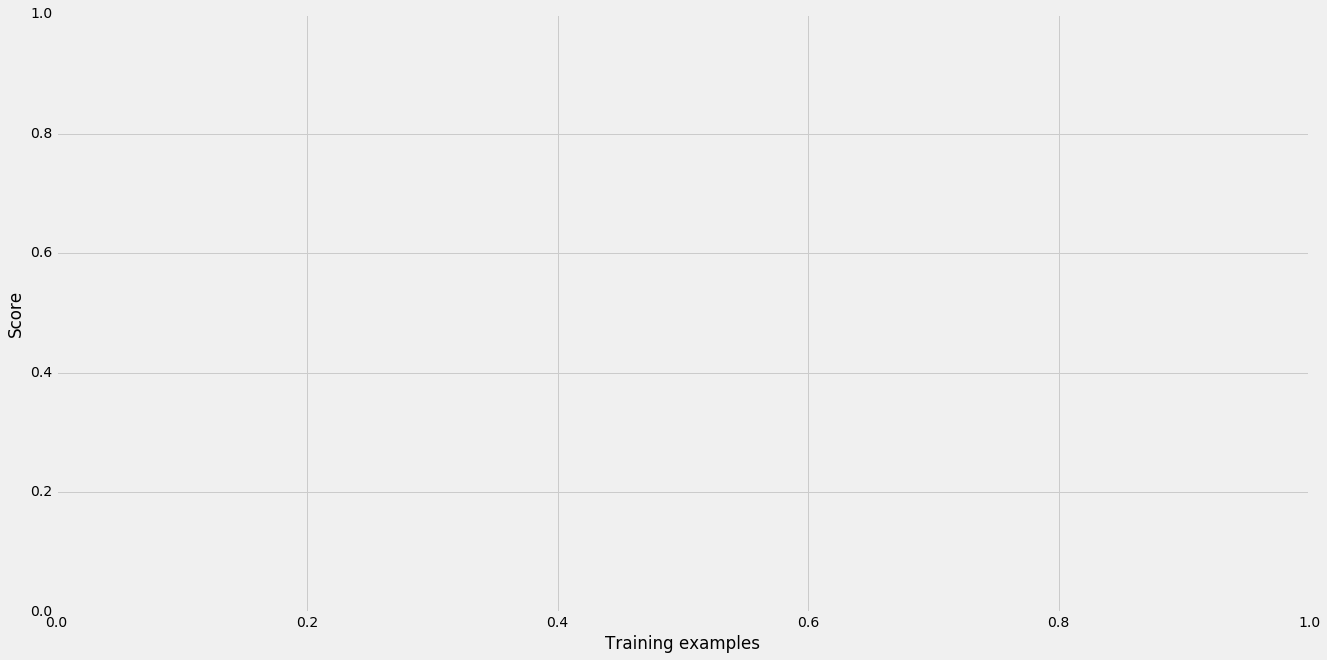

In [58]:
u.plot_learning_curve(gbc_best, "Learning curve - GradientBoostingClassifier - best", Xp_train, y_train, scoring='roc_auc')

In [61]:
gbc_best.fit(Xp_train, y_train)

GradientBoostingClassifier(init=None, learning_rate=0.12, loss='deviance',
              max_depth=5, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=5, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [62]:
print("ROC_AUC score for out-of-samle data (stratified): %0.4f" 
      % roc_auc_score(y_test, gbc_best.predict_proba(Xp_test)[:,1]))

ROC_AUC score for out-of-samle data (stratified): 0.8101


In [63]:
joblib.dump(gbc_best, 'sgdc_best.pkl')

['sgdc_best.pkl',
 'sgdc_best.pkl_01.npy',
 'sgdc_best.pkl_02.npy',
 'sgdc_best.pkl_03.npy',
 'sgdc_best.pkl_04.npy',
 'sgdc_best.pkl_05.npy',
 'sgdc_best.pkl_06.npy',
 'sgdc_best.pkl_07.npy',
 'sgdc_best.pkl_08.npy',
 'sgdc_best.pkl_09.npy',
 'sgdc_best.pkl_10.npy',
 'sgdc_best.pkl_11.npy',
 'sgdc_best.pkl_12.npy',
 'sgdc_best.pkl_13.npy',
 'sgdc_best.pkl_14.npy',
 'sgdc_best.pkl_15.npy',
 'sgdc_best.pkl_16.npy',
 'sgdc_best.pkl_17.npy',
 'sgdc_best.pkl_18.npy',
 'sgdc_best.pkl_19.npy',
 'sgdc_best.pkl_20.npy',
 'sgdc_best.pkl_21.npy',
 'sgdc_best.pkl_22.npy',
 'sgdc_best.pkl_23.npy',
 'sgdc_best.pkl_24.npy',
 'sgdc_best.pkl_25.npy',
 'sgdc_best.pkl_26.npy',
 'sgdc_best.pkl_27.npy',
 'sgdc_best.pkl_28.npy',
 'sgdc_best.pkl_29.npy',
 'sgdc_best.pkl_30.npy',
 'sgdc_best.pkl_31.npy',
 'sgdc_best.pkl_32.npy',
 'sgdc_best.pkl_33.npy',
 'sgdc_best.pkl_34.npy',
 'sgdc_best.pkl_35.npy',
 'sgdc_best.pkl_36.npy',
 'sgdc_best.pkl_37.npy',
 'sgdc_best.pkl_38.npy',
 'sgdc_best.pkl_39.npy',
 'sgdc_

### LogisticRegression

In [32]:
lr = LogisticRegression()

Stratified 3-Fold cross-validation 
train_scores_mean:
[ 0.95060419  0.94094453  0.92682697  0.93286649  0.93233975]
test_scores_mean:
[ 0.84166668  0.88720726  0.91825896  0.91551907  0.91800897]


<module 'matplotlib.pyplot' from 'e:\\Install\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

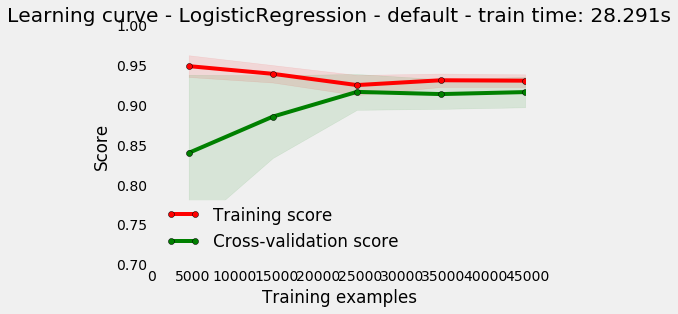

In [35]:
plot_learning_curve(lr, "Learning curve - LogisticRegression - default", X_train, y, scoring='roc_auc')

In [36]:
# specify parameters and distributions to sample from
lr_param_dist = {"penalty" : ['l1', 'l2'],
                 "tol" : np.linspace(0.0001, 0.1, 20),
                 "C" : np.linspace(0.1, 2., 20)}

# run randomized search
n_iter_search = 30
lr_random_search = RandomizedSearchCV(lr, param_distributions=lr_param_dist, n_iter=n_iter_search, scoring='roc_auc', verbose=1)
lr_random_search.fit(X_train, y)

print(lr_random_search.best_score_, lr_random_search.best_params_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:  1.9min
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  2.9min finished


0.918661331157 {'C': 0.5, 'tol': 0.0053578947368421058, 'penalty': 'l1'}


In [37]:
lr_best = LogisticRegression(penalty='l1', C=0.5, tol=0.0053578947368421058)

Stratified 3-Fold cross-validation 
train_scores_mean:
[ 0.94987434  0.93993836  0.92621017  0.93267449  0.93226679]
test_scores_mean:
[ 0.814165    0.90319459  0.91830826  0.91695424  0.91876585]


<module 'matplotlib.pyplot' from 'e:\\Install\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

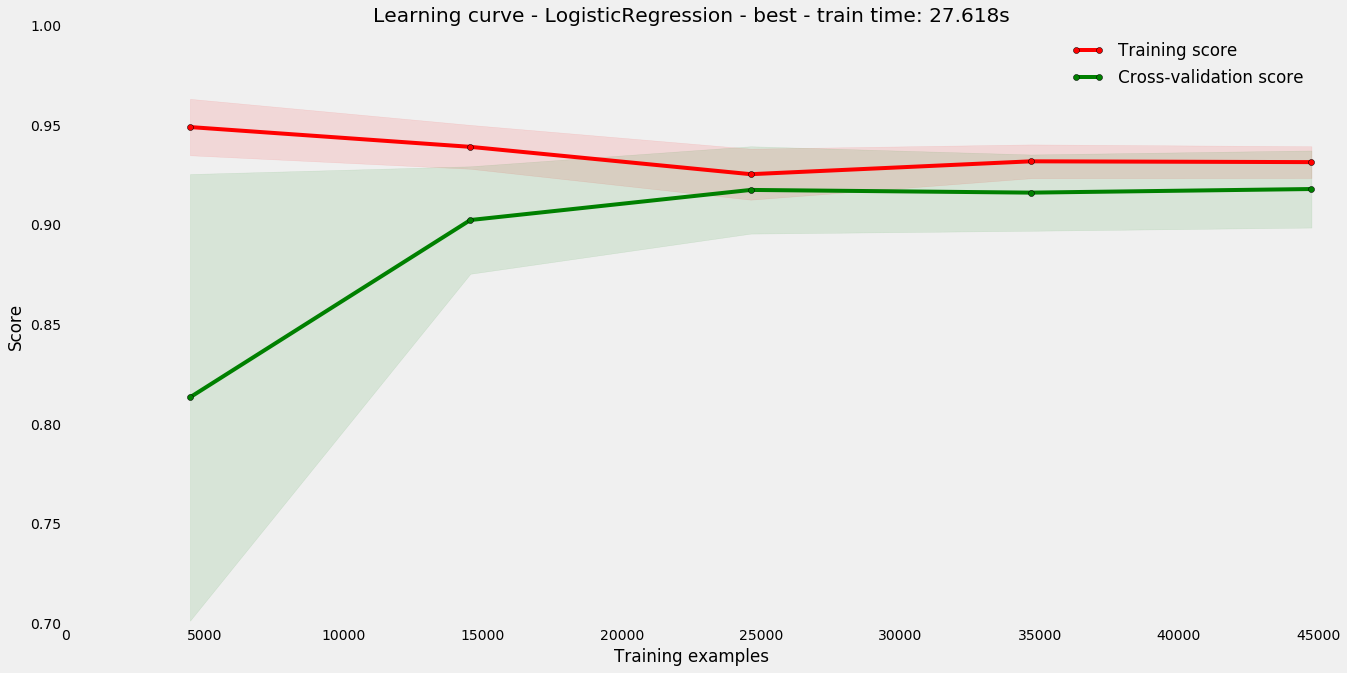

In [43]:
plot_learning_curve(lr_best, "Learning curve - LogisticRegression - best", X_train, y, scoring='roc_auc')

### SVM Linear

In [55]:
lsvc = LinearSVC()

Stratified 3-Fold cross-validation 
train_scores_mean:
[ 0.94823532  0.93760744  0.92333706  0.92805348  0.92695214]
test_scores_mean:
[ 0.84108758  0.90012359  0.91169326  0.90859265  0.91360089]


<module 'matplotlib.pyplot' from 'e:\\Install\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

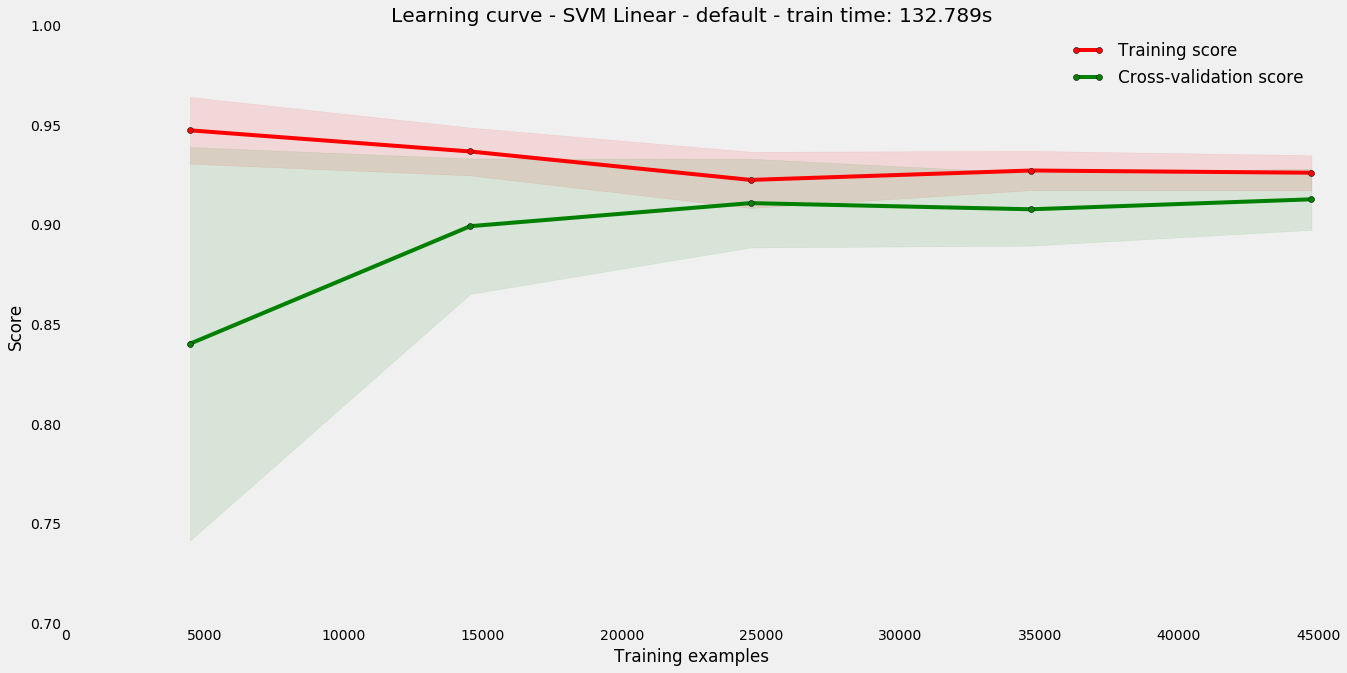

In [56]:
plot_learning_curve(lsvc, "Learning curve - SVM Linear - default", X_train, y, scoring='roc_auc')

In [57]:
# specify parameters and distributions to sample from
lsvc_param_dist = {"tol" : np.linspace(0.0001, 0.1, 20),
                 "C" : np.linspace(0.01, 2., 20)}

# run randomized search
n_iter_search = 20
lsvc_random_search = RandomizedSearchCV(lsvc, param_distributions=lsvc_param_dist, n_iter=n_iter_search, scoring='roc_auc', verbose=1)
lsvc_random_search.fit(X_train, y)

print(lsvc_random_search.best_score_, lsvc_random_search.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed: 14.9min
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 17.4min finished


0.913945932837 {'C': 0.11473684210526315, 'tol': 0.03690526315789474}


In [58]:
lsvc_best = LinearSVC(C=0.11473684210526315, tol=0.03690526315789474)

Stratified 3-Fold cross-validation 
train_scores_mean:
[ 0.94640079  0.93722358  0.92322601  0.92797309  0.92684319]
test_scores_mean:
[ 0.82929446  0.88494748  0.91278259  0.9091429   0.91393421]


<module 'matplotlib.pyplot' from 'e:\\Install\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

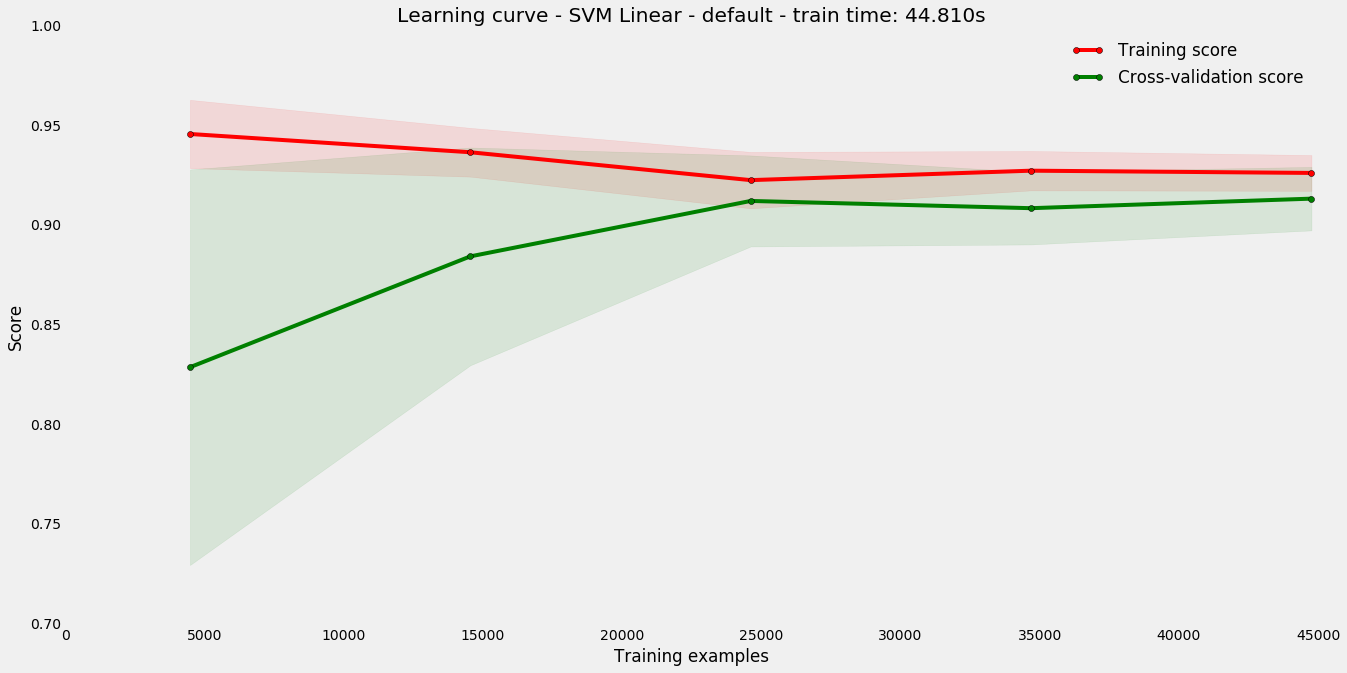

In [59]:
plot_learning_curve(lsvc_best, "Learning curve - SVM Linear - best", X_train, y, scoring='roc_auc')

### SVM RBF

In [57]:
# specify parameters and distributions to sample from
svc_rbf_param_dist = {"gamma": np.logspace(-9, 3, 13),
                 "C" : np.linspace(0.01, 2., 20)}

# run randomized search
n_iter_search = 20
lsvc_random_search = RandomizedSearchCV(lsvc, param_distributions=lsvc_param_dist, n_iter=n_iter_search, scoring='roc_auc', verbose=1)
lsvc_random_search.fit(X_train, y)

print(lsvc_random_search.best_score_, lsvc_random_search.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed: 14.9min
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 17.4min finished


0.913945932837 {'C': 0.11473684210526315, 'tol': 0.03690526315789474}


In [386]:
svc_rbf = SVC(class_weight='balanced', cache_size = 500, C= 0.1, tol= 0.0369, gamma=0.1)

Stratified 3-Fold cross-validation 
train_scores_mean:
[ 1.          0.99996938  0.9993669   0.99850052  0.99744989]
test_scores_mean:
[ 0.89151656  0.89555115  0.89751399  0.89882577  0.89935506]


<module 'matplotlib.pyplot' from 'e:\\Install\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

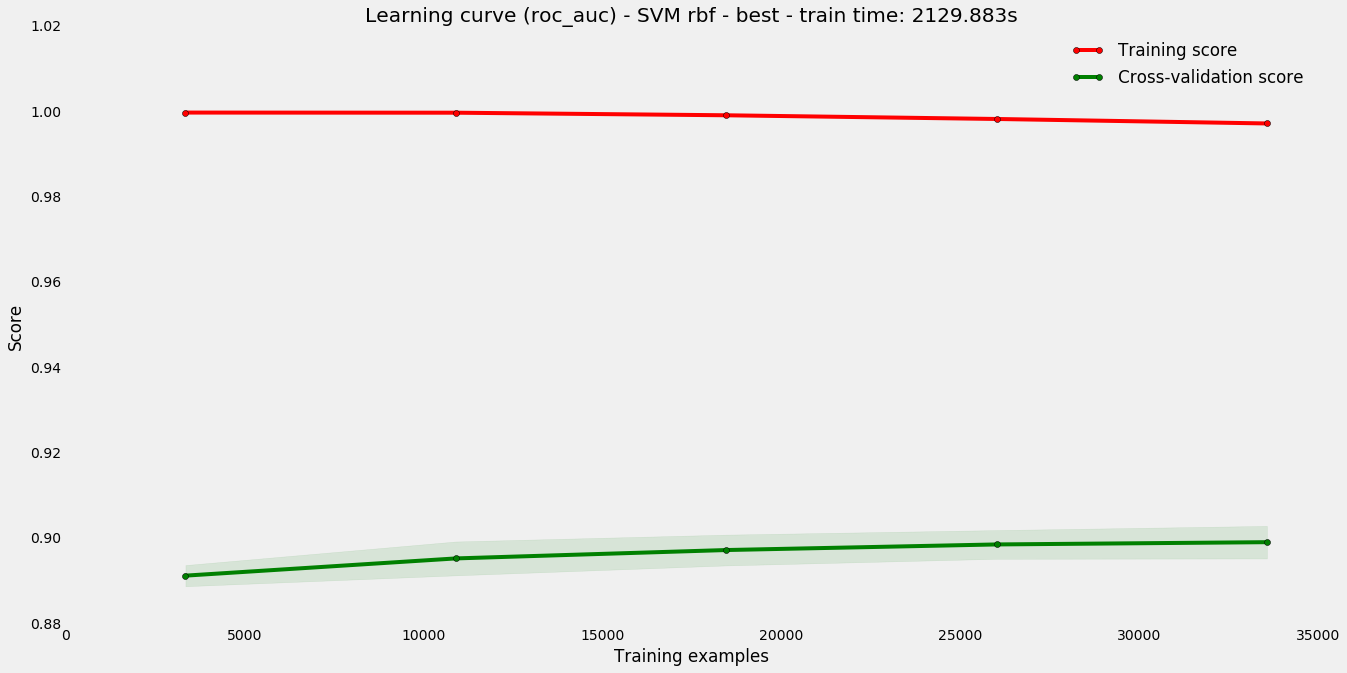

In [387]:
u.plot_learning_curve(svc_rbf, "Learning curve (roc_auc) - SVM rbf - best", Xp_train, y_train, scoring='roc_auc')

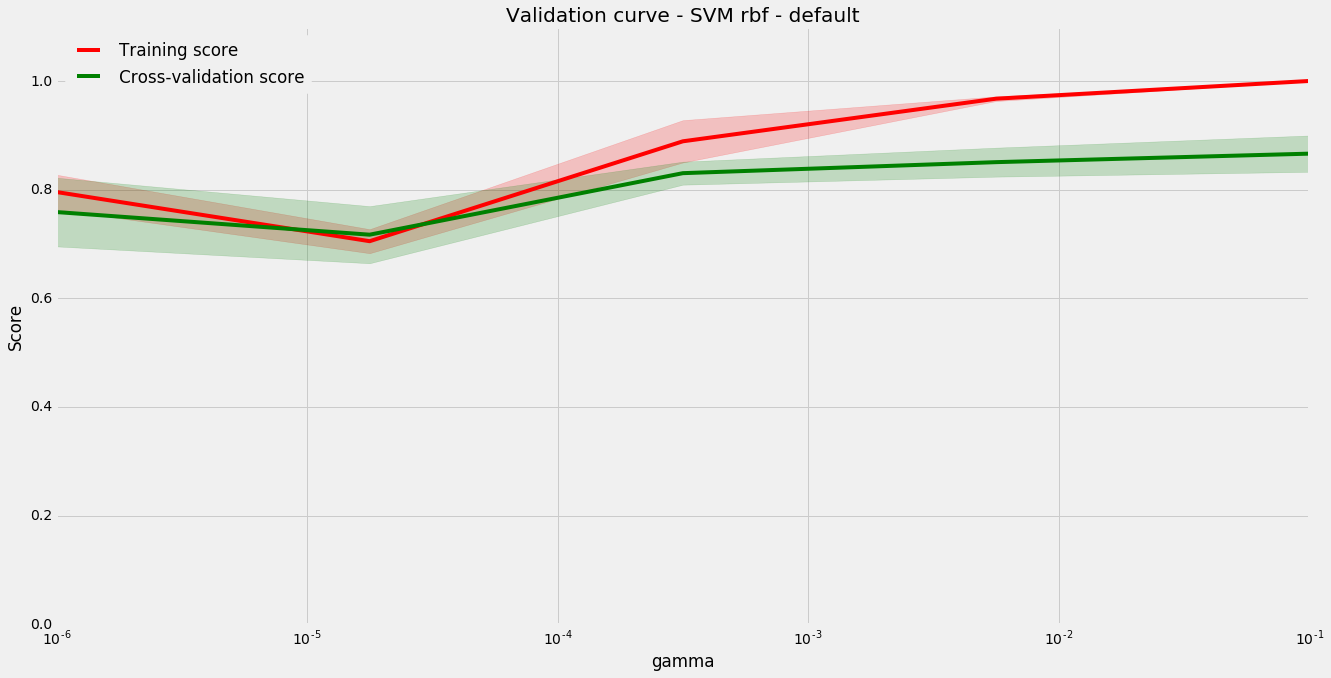

Stratified 3-Fold cross-validation 
train_scores_mean:
[ 0.79548866  0.70496904  0.88883219  0.96725684  0.99989324]
test_scores_mean:
[ 0.75861394  0.71694777  0.83017702  0.85046397  0.86611667]


<module 'matplotlib.pyplot' from 'e:\\Install\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [51]:
plot_validation_curve(svc_rbf, X_norm_ss, y, param_name="gamma", param_range = np.logspace(-5, 0, 5), 
                      title="Validation curve - SVM rbf - default", ylim=(0.0, 1.1), scoring='roc_auc')

In [ ]:
svc_rbf.fit(Xp_train, y_train)

In [388]:
print("ROC_AUC score for out-of-samle data (stratified): %0.4f" % roc_auc_score(y_test, svc_rbf.predict_proba(Xp_test)[:,1]))

AttributeError: predict_proba is not available when  probability=False

In [389]:
joblib.dump(svc_rbf, 'sgdc_best.pkl')

['sgdc_best.pkl',
 'sgdc_best.pkl_01.npy',
 'sgdc_best.pkl_02.npy',
 'sgdc_best.pkl_03.npy',
 'sgdc_best.pkl_04.npy',
 'sgdc_best.pkl_05.npy',
 'sgdc_best.pkl_06.npy',
 'sgdc_best.pkl_07.npy',
 'sgdc_best.pkl_08.npy',
 'sgdc_best.pkl_09.npy',
 'sgdc_best.pkl_10.npy',
 'sgdc_best.pkl_11.npy']

# Feature selection

In [ ]:
def forest_feature_importances (estimator, features):
    n_features = features.shape[0]
    importances = estimator.feature_importances_
    std = np.std([tree.feature_importances_ for tree in estimator.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")
    for f in range(n_features):
        print("%d. %s (%f)" % (f + 1, features[f], importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(n_features), importances[indices], color="r", yerr=std[indices], align="center")
    plt.xticks(range(n_features), features)
    plt.xlim([-1, n_features])
    plt.show()

In [ ]:
rfc = RandomForestClassifier(n_estimators= 100)

In [ ]:
rfc.fit(Xe_train, y_train)
forest_feature_importances (rfc, Xe_train.columns.values)